In [1]:
from goose import Goose
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline, make_union
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV
from bs4 import BeautifulSoup
from sklearn.neighbors import KNeighborsClassifier
from textblob import TextBlob, Word
from sklearn.base import TransformerMixin
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.grid_search import GridSearchCV
import datetime
%matplotlib inline

In [2]:
columns = ['Unnamed','url_raw', 'url_clean', 'url_domain', 'ugly_text', 'issue', 'political_lean', 'title', 'meta_description', 'cleaned_text']
use_columns = ['url_raw', 'url_clean', 'url_domain', 'ugly_text', 'issue', 'political_lean', 'title', 'meta_description', 'cleaned_text']
pld = pd.read_csv('0_16450.csv', index_col=columns, usecols=use_columns)

In [3]:
del pld['Unnamed: 0']

In [4]:
pld.columns = ['url_raw', 'url_clean', 'url_domain', 'ugly_text', 'issue', 'political_lean', 'title', 'meta_description', 'cleaned_text']
pld.head(3)

,url_raw,url_clean,url_domain,ugly_text,issue,political_lean,title,meta_description,cleaned_text
0,https://www.washingtonpost.com/news/post-natio...,washingtonpost.com/news/post-nation/wp/2016/05...,washingtonpost.com,2 Desktop notifications are ...,abortion,Lean Left,‘A target on Roe v. Wade ’: Oklahoma bill maki...,Gov. Mary Fallin (R) has not said if she plans...,UPDATE: Gov. Fallin vetoed the bill on Friday....
1,http://www.salon.com/2016/04/07/camille_paglia...,salon.com/2016/04/07/camille_paglia_feminists_...,salon.com,\n\n\t\n\t\t\n\t\t\t\n\t\t\t\t\n\t\t\t\t\t\n\t...,abortion,Left,"Camille Paglia: Feminists have abortion wrong,...",Reproductive rights have become ideological to...,"While the Hillary flap was merely a blip, give..."
2,http://www.vox.com/2016/3/20/11269226/texas-ab...,vox.com/2016/3/20/11269226/texas-abortion-wome...,vox.com,"\n \n \n\n(function(w,d,s,l,i){w[l]=w[l]...",abortion,Lean Left,Study: women had to drive 4 times farther afte...,Here's exactly how Texas anti-abortion laws bu...,Ever since Texas laws closed about half of the...


In [5]:
pld_text = pld[pld['cleaned_text'].notnull()]
pld_text[['cleaned_text', 'url_domain', 'political_lean', 'issue', 'title']].count()

cleaned_text      12817
url_domain        12817
political_lean    12817
issue             12817
title             12778
dtype: int64

In [ ]:
# PIPELINE CAN ALSO BE USED WITH GRIDSEARCHCV, BUT VERY SLOW
# pipe = Pipeline([
#   ('features', FeatureUnion([
#         ('counts', CountVectorizer()),
#         ('tf_idf', TfidfVectorizer())
#   ])),
#   ('classifier', MultinomialNB())
# ])

# SEARCH FOR AN OPTIMAL N_GRAM VALUE USING GRADSEARCHCV
# gram_range = [(1, n) for n in range(1, 3)]
# param_grid = {
#     'features__counts__ngram_range': gram_range,
#     'features__tf_idf__ngram_range': gram_range,
# }

# grid = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy')
# grid.fit(df.msg, df.label)
# print grid.best_score_, grid.best_params_

In [9]:
time = datetime.datetime.now()

pipe = Pipeline([
  ('features', FeatureUnion([
        ('counts', CountVectorizer())
  ])),
  ('logreg', LogisticRegression())
])

print cross_val_score(pipe, pld_text.cleaned_text, pld_text.political_lean, cv=5, scoring='accuracy').mean()

print datetime.datetime.now() - time

0.581698121969
0:05:05.378078


In [10]:
time = datetime.datetime.now()

pipe = Pipeline([
  ('features', FeatureUnion([
        ('counts', CountVectorizer())
  ])),
  ('classifier', MultinomialNB())
])

print cross_val_score(pipe, pld_text.cleaned_text, pld_text.political_lean, cv=5, scoring='accuracy').mean()

print datetime.datetime.now() - time

0.463778334447
0:00:42.478829


In [204]:
time = datetime.datetime.now()

pipe = Pipeline([
  ('features', FeatureUnion([
        ('counts', CountVectorizer()),
        ('tf_idf', TfidfVectorizer())
  ])),
  ('logreg', LogisticRegression())
])

print cross_val_score(pipe, pld_text.cleaned_text, pld_text.political_lean, cv=5, scoring='accuracy').mean()

print datetime.datetime.now() - time

0.587583794081
0:08:32.436998


In [206]:
time = datetime.datetime.now()

pipe = Pipeline([
  ('features', FeatureUnion([
        ('counts', CountVectorizer()),
        ('tf_idf', TfidfVectorizer())
  ])),
  ('classifier', MultinomialNB())
])

print cross_val_score(pipe, pld_text.cleaned_text, pld_text.political_lean, cv=5, scoring='accuracy').mean()

print datetime.datetime.now() - time

0.496657158128
0:01:25.248623


In [6]:
class Domain(TransformerMixin):

    def transform(self, X, **transform_params):
        domains = self.vect.transform(X.url_domain)
        return domains

    def fit(self, X, y=None, **fit_params):
        self.vect = CountVectorizer(**fit_params)
        self.vect.fit(X['url_domain'])
        return self

In [7]:
class WordVect(TransformerMixin):

    def transform(self, X, **transform_params):
        words = self.vect.transform(X.cleaned_text)
        return words

    def fit(self, X, y=None, **fit_params):
        self.vect = CountVectorizer(**fit_params)
        self.vect.fit(X['cleaned_text'])
        return self

In [13]:
time = datetime.datetime.now()

pipe = Pipeline([
  ('features', FeatureUnion([
        ('words', WordVect()),
        ('domain', Domain())
  ])),
  ('classifier', LogisticRegression())
])

print cross_val_score(pipe, pld_text, pld_text['political_lean'], cv=5, scoring='accuracy', n_jobs=-1).mean()

print datetime.datetime.now() - time

WordVectorizer:
(9999, 57965)
DomainVectorizer:
(9999, 165)
WordVectorizer:
(10000, 58137)
DomainVectorizer:
(10000, 153)
WordVectorizer:
(10000, 58492)
DomainVectorizer:
(10000, 170)
WordVectorizer:
(10002, 57278)
DomainVectorizer:
(10002, 157)
WordVectorizer:
(2502, 57965)
DomainVectorizer:
(2502, 165)
WordVectorizer:
(2499, 57278)
DomainVectorizer:
(2499, 157)
WordVectorizer:
(2501, 58137)
DomainVectorizer:
(2501, 153)
WordVectorizer:
(2501, 58492)
DomainVectorizer:
(2501, 170)
WordVectorizer:
(10003, 57929)
DomainVectorizer:
(10003, 167)
WordVectorizer:
(2498, 57929)
DomainVectorizer:
(2498, 167)
0.853034443257
0:03:12.789926


In [16]:
time = datetime.datetime.now()

pipe = Pipeline([
  ('features', FeatureUnion([
        ('counts', CountVectorizer(stop_words='english'))
  ])),
  ('logreg', LogisticRegression())
])

print cross_val_score(pipe, pld_text['cleaned_text'], pld_text.political_lean, cv=5, scoring='accuracy').mean()

print datetime.datetime.now() - time

0.569940582322
0:03:00.713157


In [18]:
time = datetime.datetime.now()

pipe = Pipeline([
  ('features', FeatureUnion([
        ('counts', CountVectorizer(stop_words='english'))
  ])),
  ('classifier', MultinomialNB())
])

print cross_val_score(pipe, pld_text['cleaned_text'], pld_text.political_lean, cv=5, scoring='accuracy').mean()

print datetime.datetime.now() - time

0.461698717961
0:00:44.510973


In [54]:
time = datetime.datetime.now()

pipe = Pipeline([
  ('features', FeatureUnion([
        ('counts', CountVectorizer(ngram_range=(1, 2), min_df=3))
  ])),
  ('logreg', LogisticRegression())
])

print cross_val_score(pipe, pld_text['cleaned_text'], pld_text.political_lean, cv=5, scoring='accuracy').mean()

print datetime.datetime.now() - time

0.622210627145
0:16:07.465197


In [ ]:
aboveabove

In [7]:
def pipe(col):
    time = datetime.datetime.now()
    pld_issue = pld_text[pld_text.issue == col]
    if pld_issue['cleaned_text'].count() > 5:
        pipe = Pipeline([
          ('features', FeatureUnion([
                ('counts', CountVectorizer())
          ])),
          ('logreg', LogisticRegression())
        ])
        print " "
        print "issue: " + str(col)
        print cross_val_score(pipe, pld_issue['cleaned_text'], pld_issue.political_lean, cv=5, scoring='accuracy').mean()
        print datetime.datetime.now() - time

In [31]:
top_six_cols = pld_text.issue.unique()  #['election-2012', 'healthcare-0', 'immigration', 'economic-policy-debt-deficit', 'economy-jobs', 'gun-legislation']
for col in top_six_cols:
    pipe(col)

 
issue: abortion
0.460374396135
0:00:01.158694
 
issue: asia
0.269761904762
0:00:00.278807
 
issue: campaign-finance
0.548534798535
0:00:00.394141
 
issue: civil-rights
0.436969657875
0:00:02.179912
 
issue: cia
0.534017094017
0:00:00.557582
 
issue: foreign-policy


/Users/stanleystevensWhistle/miniconda2/envs/stanleyyork/lib/python2.7/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)


0.45219279201
0:00:03.083598
 
issue: gay-rights
0.393599336178
0:00:01.971592
 
issue: us-congress
0.494039294039
0:00:01.897374
 
issue: us-house-representatives
0.410714285714
0:00:01.366856
 
issue: criminal-justice
0.488528138528
0:00:00.401921
 
issue: defense
0.413758912656
0:00:00.986979
 
issue: democrat-party
0.490361812101
0:00:00.780160
 
issue: education
0.410294473377
0:00:02.571426
 
issue: domestic-policy
0.273333333333
0:00:00.108451
 
issue: economic-policy
0.406415954416
0:00:00.957803
 
issue: elections
0.574809067416
0:00:03.228309
 
issue: election-2012
0.591405090095
0:00:47.487605
 
issue: economy-jobs
0.560315790971
0:00:03.873658
 
issue: economic-policy-debt-deficit
0.572712600216
0:00:05.733343
 
issue: environment
0.445716345659
0:00:02.601595
 
issue: free-speech
0.406666666667
0:00:00.391962
 
issue: gun-legislation
0.469886876366
0:00:04.977387
 
issue: immigration
0.550232077636
0:00:05.082927
 
issue: energy
0.386260683761
0:00:00.553614
 
issue: justi

/Users/stanleystevensWhistle/miniconda2/envs/stanleyyork/lib/python2.7/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)


0.602989695589
0:00:07.744309
 
issue: israel
0.531944444444
0:00:00.497304
 
issue: labor
0.483888888889
0:00:00.221904
 
issue: media-watchmedia-bias
0.55697252733
0:00:03.642402
 
issue: medicare
0.508441558442
0:00:00.373096
 
issue: middle-east
0.452151990145
0:00:01.685291


In [8]:
class GetText(TransformerMixin):

    def transform(self, X, **transform_params):
        domains = X.cleaned_text
        return domains

    def fit(self, X, y=None, **fit_params):
        return self

In [62]:
time = datetime.datetime.now()

pipe = Pipeline([
  ('features', FeatureUnion([
    ('word', Pipeline([
      ('gettext', GetText()),
      ('counts', CountVectorizer())
    ])),
    ('domain', Domain())
  ])),
  ('classifier', MultinomialNB())
])

print cross_val_score(pipe, pld_text, pld_text['political_lean'], cv=5, scoring='accuracy', n_jobs=-1).mean()

print datetime.datetime.now() - time

0.604970517794
0:00:38.221002


In [61]:
time = datetime.datetime.now()

pipe = Pipeline([
  ('features', FeatureUnion([
    ('word', Pipeline([
      ('gettext', GetText()),
      ('counts', CountVectorizer())
    ])),
    ('domain', Domain())
  ])),
  ('logreg', LogisticRegression())
])

print cross_val_score(pipe, pld_text, pld_text['political_lean'], cv=5, scoring='accuracy', n_jobs=-1).mean()

print datetime.datetime.now() - time

0.853034443257
0:03:16.615209


In [64]:
time = datetime.datetime.now()

pipe = Pipeline([
  ('features', FeatureUnion([
    ('word', Pipeline([
      ('gettext', GetText()),
      ('counts', CountVectorizer(min_df=4))
    ])),
    ('domain', Domain())
  ])),
  ('logreg', LogisticRegression())
])

print cross_val_score(pipe, pld_text, pld_text['political_lean'], cv=5, scoring='accuracy', n_jobs=-1).mean()

print datetime.datetime.now() - time

0.853834539577
0:03:34.059663


In [57]:
time = datetime.datetime.now()

pipe = Pipeline([
  ('features', FeatureUnion([
    ('word', Pipeline([
      ('gettext', GetText()),
      ('counts', CountVectorizer(ngram_range=(1, 2), min_df=2))
    ])),
    ('domain', Domain())
  ])),
  ('logreg', LogisticRegression())
])

print cross_val_score(pipe, pld_text, pld_text['political_lean'], cv=5, scoring='accuracy', n_jobs=-1).mean()

print datetime.datetime.now() - time

0.825038082707
0:15:43.350393


In [58]:
time = datetime.datetime.now()

pipe = Pipeline([
  ('features', FeatureUnion([
    ('word', Pipeline([
      ('gettext', GetText()),
      ('counts', CountVectorizer(ngram_range=(1, 2), min_df=4))
    ])),
    ('domain', Domain())
  ])),
  ('logreg', LogisticRegression())
])

print cross_val_score(pipe, pld_text, pld_text['political_lean'], cv=5, scoring='accuracy', n_jobs=-1).mean()

print datetime.datetime.now() - time

0.829117092128
0:11:23.004279


In [59]:
time = datetime.datetime.now()

pipe = Pipeline([
  ('features', FeatureUnion([
    ('word', Pipeline([
      ('gettext', GetText()),
      ('counts', CountVectorizer(ngram_range=(1, 2), min_df=3))
    ])),
    ('domain', Domain())
  ])),
  ('logreg', LogisticRegression())
])

print cross_val_score(pipe, pld_text, pld_text['political_lean'], cv=5, scoring='accuracy', n_jobs=-1).mean()

print datetime.datetime.now() - time

0.827037699142
0:14:29.761025


In [65]:
time = datetime.datetime.now()

pipe = Pipeline([
  ('features', FeatureUnion([
    ('word', Pipeline([
      ('gettext', GetText()),
      ('counts', CountVectorizer(ngram_range=(1, 3), min_df=4))
    ])),
    ('domain', Domain())
  ])),
  ('logreg', LogisticRegression())
])

print cross_val_score(pipe, pld_text, pld_text['political_lean'], cv=5, scoring='accuracy', n_jobs=-1).mean()

print datetime.datetime.now() - time

0.819597408492
0:24:33.104491


In [9]:
class Issue(TransformerMixin):

    def transform(self, X, **transform_params):
        domains = self.vect.transform(X.issue)
        return domains

    def fit(self, X, y=None, **fit_params):
        self.vect = CountVectorizer(**fit_params)
        self.vect.fit(X['issue'])
        return self

In [72]:
time = datetime.datetime.now()

pipe = Pipeline([
  ('features', FeatureUnion([
    ('word', Pipeline([
      ('gettext', GetText()),
      ('counts', CountVectorizer(min_df=4, max_features=25000))
    ])),
    ('domain', Domain())
  ])),
  ('logreg', LogisticRegression())
])

print cross_val_score(pipe, pld_text, pld_text['political_lean'], cv=5, scoring='accuracy', n_jobs=-1).mean()

print datetime.datetime.now() - time

0.853674571513
0:03:12.073189


In [73]:
time = datetime.datetime.now()

pipe = Pipeline([
  ('features', FeatureUnion([
    ('word', Pipeline([
      ('gettext', GetText()),
      ('counts', CountVectorizer(min_df=4))
    ])),
    ('domain', Domain()),
    ('issue', Issue())
  ])),
  ('logreg', LogisticRegression())
])

print cross_val_score(pipe, pld_text, pld_text['political_lean'], cv=5, scoring='accuracy', n_jobs=-1).mean()

print datetime.datetime.now() - time

0.852394251154
0:02:20.039432


In [10]:
class Url(TransformerMixin):

    def transform(self, X, **transform_params):
        domains = self.vect.transform(X.url_raw)
        return domains

    def fit(self, X, y=None, **fit_params):
        self.vect = CountVectorizer(**fit_params)
        self.vect.fit(X['url_raw'])
        return self

In [81]:
time = datetime.datetime.now()

pipe = Pipeline([
  ('features', FeatureUnion([
    ('word', Pipeline([
      ('gettext', GetText()),
      ('counts', CountVectorizer(min_df=4))
    ])),
    ('domain', Domain()),
    ('url', Url())
  ])),
  ('logreg', LogisticRegression())
])

print cross_val_score(pipe, pld_text, pld_text['political_lean'], cv=5, scoring='accuracy', n_jobs=-1).mean()

print datetime.datetime.now() - time

0.900953915603
0:03:05.730800


In [22]:
pld_text['cleaned_text_length'] = pld_text['cleaned_text'].apply(lambda x: len(x))

/Users/stanleystevensWhistle/miniconda2/envs/stanleyyork/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [17]:
pld_text.cleaned_text_length.max()

85488

In [11]:
class WordCount(TransformerMixin):

    def transform(self, X, **transform_params):
        count = X.cleaned_text_length
        return count

    def fit(self, X, y=None, **fit_params):
        return self

In [12]:
class Sentiment(TransformerMixin):

    def transform(self, X, **transform_params):
        sentiment = X.sentiment#self.vect.transform(X.sentiment)
        return sentiment

    def fit(self, X, y=None, **fit_params):
#         self.vect = CountVectorizer(**fit_params)
#         self.vect.fit(X['sentiment'])
        return self
    
class Subjectivity(TransformerMixin):

    def transform(self, X, **transform_params):
        sentiment = self.vect.transform(X.subjectivity)
        return sentiment

    def fit(self, X, y=None, **fit_params):
        self.vect = CountVectorizer(**fit_params)
        self.vect.fit(X['subjectivity'])
        return self

In [13]:
from textblob import TextBlob, Word

def create_sentiment(str):
    try:
        tb = TextBlob(str)
        return tb.sentiment.subjectivity
    except Exception as e:
        tb = TextBlob(str.decode('utf-8'))
        return tb.sentiment.subjectivity
    except Exception as e:
        pass
    

pld_text['subjectivity'] = pld_text['cleaned_text'].apply(lambda x: create_sentiment(x))

/Users/stanleystevensWhistle/miniconda2/envs/stanleyyork/lib/python2.7/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [14]:
from textblob import TextBlob, Word

def create_sentiment(str):
    try:
        tb = TextBlob(str)
        return tb.sentiment.polarity
    except Exception as e:
        tb = TextBlob(str.decode('utf-8'))
        return tb.sentiment.polarity
    except Exception as e:
        pass
    

pld_text['sentiment'] = pld_text['cleaned_text'].apply(lambda x: create_sentiment(x))

/Users/stanleystevensWhistle/miniconda2/envs/stanleyyork/lib/python2.7/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [23]:
print pld_text['subjectivity'].isnull().sum()
print pld_text['sentiment'].isnull().sum()

0
0


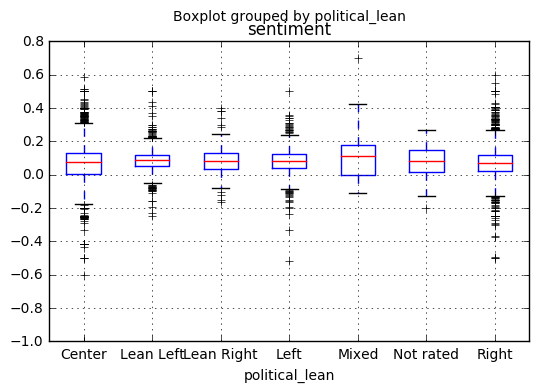

In [31]:
pld_text.boxplot(column='sentiment', by='political_lean')

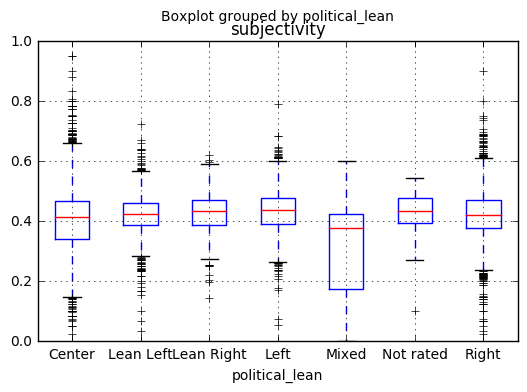

In [32]:
pld_text.boxplot(column='subjectivity', by='political_lean')

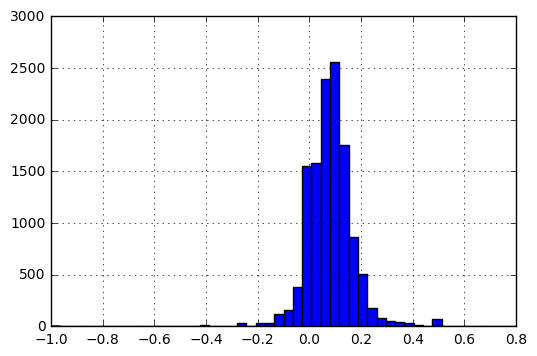

In [37]:
pld_text['sentiment'].hist(bins=50)

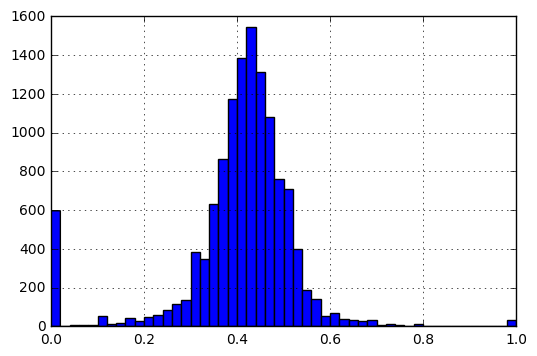

In [38]:
pld_text['subjectivity'].hist(bins=50)

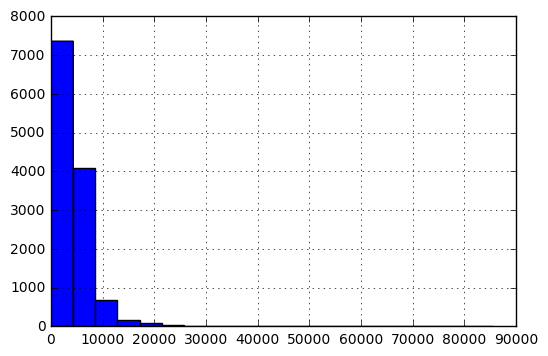

In [24]:
pld_text['cleaned_text_length'].hist(bins=20)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13caab750>]], dtype=object)

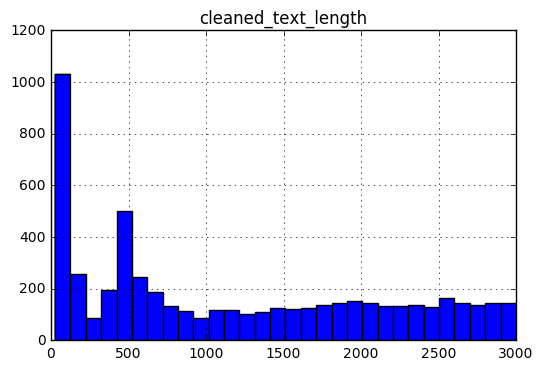

In [25]:
pld_text[pld_text.cleaned_text_length < 3000].hist(bins=30)

In [43]:
pld_text.head()

,url_raw,url_clean,url_domain,ugly_text,issue,political_lean,title,meta_description,cleaned_text,sentiment,subjectivity,cleaned_text_length
0,https://www.washingtonpost.com/news/post-natio...,washingtonpost.com/news/post-nation/wp/2016/05...,washingtonpost.com,2 Desktop notifications are ...,abortion,Lean Left,‘A target on Roe v. Wade ’: Oklahoma bill maki...,Gov. Mary Fallin (R) has not said if she plans...,UPDATE: Gov. Fallin vetoed the bill on Friday....,0.064502,0.425226,6839
1,http://www.salon.com/2016/04/07/camille_paglia...,salon.com/2016/04/07/camille_paglia_feminists_...,salon.com,\n\n\t\n\t\t\n\t\t\t\n\t\t\t\t\n\t\t\t\t\t\n\t...,abortion,Left,"Camille Paglia: Feminists have abortion wrong,...",Reproductive rights have become ideological to...,"While the Hillary flap was merely a blip, give...",0.075956,0.461114,12083
2,http://www.vox.com/2016/3/20/11269226/texas-ab...,vox.com/2016/3/20/11269226/texas-abortion-wome...,vox.com,"\n \n \n\n(function(w,d,s,l,i){w[l]=w[l]...",abortion,Lean Left,Study: women had to drive 4 times farther afte...,Here's exactly how Texas anti-abortion laws bu...,Ever since Texas laws closed about half of the...,0.115284,0.502172,4052
3,http://www.huffingtonpost.com/entry/john-kasic...,huffingtonpost.com/entry/john-kasich-planned-p...,huffingtonpost.com,\n\n\n\r\nh2.mp_title { line-height: 1.0; marg...,abortion,Left,Moderate John Kasich Just Defunded Planned Par...,The bill will strip $1.3 million that was dest...,While the bill grants an exemption to abortion...,-0.012407,0.397963,2779
4,http://www.wsj.com/articles/hillary-clinton-an...,wsj.com/articles/hillary-clinton-and-donald-tr...,wsj.com,\n\n \n\n \n\n \n\n \n \n ...,abortion,Center,Hillary Clinton and Donald Trump Duel Over Hig...,Donald Trump and Hillary Clinton plunged into ...,The long-expected endorsement by President Bar...,0.000000,0.390000,675


In [15]:
import scipy as sp
# extra = sp.sparse.csr_matrix(pld_text[['sentiment', 'subjectivity', 'cleaned_text_length']].astype(float))
# extra.shape

In [16]:
class Combined(TransformerMixin):

    def transform(self, X, **transform_params):
        extra = sp.sparse.csr_matrix(X[['sentiment', 'subjectivity', 'cleaned_text_length']].astype(float))
        return extra

    def fit(self, X, y=None, **fit_params):
        return self

In [60]:
time = datetime.datetime.now()

pipe = Pipeline([
  ('features', FeatureUnion([
    ('combined', Combined())
  ])),
  ('logreg', LogisticRegression())
])

print cross_val_score(pipe, pld_text, pld_text['political_lean'], cv=5, scoring='accuracy', n_jobs=-1).mean()

print datetime.datetime.now() - time

0.392688394669
0:00:12.778085


In [61]:
time = datetime.datetime.now()

pipe = Pipeline([
  ('features', FeatureUnion([
    ('word', Pipeline([
      ('gettext', GetText()),
      ('counts', CountVectorizer(min_df=4))
    ])),
    ('combined', Combined())
  ])),
  ('logreg', LogisticRegression())
])

print cross_val_score(pipe, pld_text, pld_text['political_lean'], cv=5, scoring='accuracy', n_jobs=-1).mean()

print datetime.datetime.now() - time

0.59882277051
0:02:54.205834


In [59]:
time = datetime.datetime.now()

pipe = Pipeline([
  ('features', FeatureUnion([
    ('word', Pipeline([
      ('gettext', GetText()),
      ('counts', CountVectorizer(min_df=4))
    ])),
    ('domain', Domain()),
    ('url', Url()),
    ('combined', Combined())
  ])),
  ('logreg', LogisticRegression())
])

print cross_val_score(pipe, pld_text, pld_text['political_lean'], cv=5, scoring='accuracy', n_jobs=-1).mean()

print datetime.datetime.now() - time

0.895752857542
0:02:27.928482


In [17]:
class CombinedDense(TransformerMixin):

    def transform(self, X, **transform_params):
        extra = X[['sentiment', 'subjectivity', 'cleaned_text_length']]
        return extra

    def fit(self, X, y=None, **fit_params):
        return self

In [18]:
class DenseTransformer(TransformerMixin):

    def transform(self, X, y=None, **fit_params):
        return X.todense()

    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y, **fit_params)
        return self.transform(X)

    def fit(self, X, y=None, **fit_params):
        return self

In [47]:
from sklearn.naive_bayes import GaussianNB

time = datetime.datetime.now()

pipe = Pipeline([
  ('features', FeatureUnion([
    ('word', Pipeline([
      ('gettext', GetText()),
      ('counts', CountVectorizer(min_df=4)),
      ('to_dense', DenseTransformer())
    ])),
    ('domain', Pipeline([
      ('domain', Domain()),
      ('to_dense', DenseTransformer())
    ])),
    ('url', Pipeline([
      ('url', Url()),
      ('to_dense', DenseTransformer())
    ])),
    ('other', Pipeline([
      ('combined', Combined()),
      ('to_dense', DenseTransformer())
    ])),
  ])),
  ('classifier', GaussianNB())
])

print cross_val_score(pipe, pld_text, pld_text['political_lean'], cv=5, scoring='accuracy', n_jobs=-1).mean()

print datetime.datetime.now() - time

0.266376093772
0:03:03.962120


In [48]:
from sklearn.naive_bayes import GaussianNB

time = datetime.datetime.now()

pipe = Pipeline([
  ('features', FeatureUnion([
    ('word', Pipeline([
      ('gettext', GetText()),
      ('counts', CountVectorizer(min_df=4)),
      ('to_dense', DenseTransformer())
    ])),
    ('domain', Pipeline([
      ('domain', Domain()),
      ('to_dense', DenseTransformer())
    ])),
    ('url', Pipeline([
      ('url', Url()),
      ('to_dense', DenseTransformer())
    ])),
  ])),
  ('classifier', GaussianNB())
])

print cross_val_score(pipe, pld_text, pld_text['political_lean'], cv=5, scoring='accuracy', n_jobs=-1).mean()

print datetime.datetime.now() - time

0.595228623634
0:03:04.073929


In [50]:
from sklearn.naive_bayes import GaussianNB

time = datetime.datetime.now()

pipe = Pipeline([
  ('features', FeatureUnion([
    ('word', Pipeline([
      ('gettext', GetText()),
      ('counts', CountVectorizer(min_df=4)),
      ('to_dense', DenseTransformer())
    ])),
    ('domain', Pipeline([
      ('domain', Domain()),
      ('to_dense', DenseTransformer())
    ])),
    ('url', Pipeline([
      ('url', Url()),
      ('to_dense', DenseTransformer())
    ])),
    ('other', Pipeline([
      ('combined', Combined()),
      ('to_dense', DenseTransformer())
    ])),
  ])),
  ('logreg', LogisticRegression())
])

print cross_val_score(pipe, pld_text, pld_text['political_lean'], cv=5, scoring='accuracy', n_jobs=-1).mean()

print datetime.datetime.now() - time

0.895752857542
0:02:32.843921


In [40]:
pld_text['binary_lean'] = pld_text['political_lean'].apply(lambda x: 'Left' if ((x == 'Lean Left') | (x == 'Left')) else 'Right' if ((x == 'Lean Right' ) | (x == 'Right')) else 'Other')

/Users/stanleystevensWhistle/miniconda2/envs/stanleyyork/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [48]:
time = datetime.datetime.now()

pipe = Pipeline([
  ('features', FeatureUnion([
    ('word', Pipeline([
      ('gettext', GetText()),
      ('counts', CountVectorizer(min_df=4))
    ])),
    ('domain', Domain()),
    ('url', Url())
  ])),
  ('logreg', LogisticRegression())
])

print cross_val_score(pipe, pld_text, pld_text['binary_lean'], cv=5, scoring='accuracy', n_jobs=-1).mean()

print datetime.datetime.now() - time

0.912880334123
0:01:45.018612


In [50]:
# from sklearn.tree import DecisionTreeClassifier
# treeclf = DecisionTreeClassifier(max_depth=10, random_state=1)
# treeclf.fit(X, y)


In [23]:
from sklearn.naive_bayes import GaussianNB

time = datetime.datetime.now()

pipe = Pipeline([
  ('features', FeatureUnion([
    ('word', Pipeline([
      ('gettext', GetText()),
      ('counts', CountVectorizer(min_df=4)),
      ('to_dense', DenseTransformer())
    ])),
#     ('domain', Pipeline([
#       ('domain', Domain()),
#       ('to_dense', DenseTransformer())
#     ])),
#     ('url', Pipeline([
#       ('url', Url()),
#       ('to_dense', DenseTransformer())
#     ])),
    ('other', Pipeline([
      ('combined', Combined()),
      ('to_dense', DenseTransformer())
    ])),
  ])),
  ('logreg', LogisticRegression())
])

print cross_val_score(pipe, pld_text, pld_text['political_lean'], cv=5, scoring='accuracy', n_jobs=-1).mean()

print datetime.datetime.now() - time

0.597237105001
0:03:33.645147


In [24]:
from sklearn.naive_bayes import GaussianNB

time = datetime.datetime.now()

pipe = Pipeline([
  ('features', FeatureUnion([
    ('word', Pipeline([
      ('gettext', GetText()),
      ('counts', CountVectorizer(min_df=4)),
      ('to_dense', DenseTransformer())
    ])),
#     ('domain', Pipeline([
#       ('domain', Domain()),
#       ('to_dense', DenseTransformer())
#     ])),
#     ('url', Pipeline([
#       ('url', Url()),
#       ('to_dense', DenseTransformer())
#     ])),
    ('issues', Pipeline([
      ('issue', Issue()),
      ('to_dense', DenseTransformer())
    ])),
    ('other', Pipeline([
      ('combined', Combined()),
      ('to_dense', DenseTransformer())
    ])),
  ])),
  ('logreg', LogisticRegression())
])

print cross_val_score(pipe, pld_text, pld_text['political_lean'], cv=5, scoring='accuracy', n_jobs=-1).mean()

print datetime.datetime.now() - time

0.586621459988
0:03:19.556015


In [19]:
from nltk.stem.snowball import SnowballStemmer
from nltk import word_tokenize     
stemmer = SnowballStemmer('english')

def word_tokenize(text, how='lemma'):
    words = TextBlob(text).words
    if how == 'lemma':
        return [word.lemmatize() for word in words]
    elif how == 'stem':
        return [stemmer.stem(word) for word in words]
    
    
stemmer = SnowballStemmer('english')
def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    tokens = TextBlob(text).words
    stems = stem_tokens(tokens, stemmer)
    return stems

In [44]:
from sklearn.naive_bayes import GaussianNB

time = datetime.datetime.now()

pipe = Pipeline([
  ('features', FeatureUnion([
    ('word', Pipeline([
      ('gettext', GetText()),
      ('counts', CountVectorizer(tokenizer=tokenize)),
      ('to_dense', DenseTransformer())
    ])),
#     ('domain', Pipeline([
#       ('domain', Domain()),
#       ('to_dense', DenseTransformer())
#     ])),
#     ('url', Pipeline([
#       ('url', Url()),
#       ('to_dense', DenseTransformer())
#     ])),
#     ('other', Pipeline([
#       ('combined', Combined()),
#       ('to_dense', DenseTransformer())
#     ])),
  ])),
  ('logreg', LogisticRegression())
])

print cross_val_score(pipe, pld_text, pld_text['political_lean'], cv=5, scoring='accuracy', n_jobs=-1).mean()

print datetime.datetime.now() - time

0.61221645315
0:27:50.525245


In [ ]:
from sklearn.naive_bayes import GaussianNB

time = datetime.datetime.now()

pipe = Pipeline([
  ('features', FeatureUnion([
    ('word', Pipeline([
      ('gettext', GetText()),
      ('counts', CountVectorizer(tokenizer=tokenize, ngram_range=(1, 2))),
      ('to_dense', DenseTransformer())
    ])),
  ('logreg', LogisticRegression())
])

print cross_val_score(pipe, pld_text, pld_text['political_lean'], cv=5, scoring='accuracy', n_jobs=-1).mean()

print datetime.datetime.now() - time

In [ ]:
time = datetime.datetime.now()

pipe = Pipeline([
  ('features', FeatureUnion([
        ('counts', CountVectorizer())
  ])),
  ('logreg', LogisticRegression())
])

gram_range = [(1, n) for n in range(1, 5)]
param_grid = {
    'features__counts__ngram_range': gram_range
}

grid = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy')
grid.fit(pld_text['cleaned_text'], pld_text['political_lean'])
print grid.best_score_, grid.best_params_
   
print datetime.datetime.now() - time

In [ ]:
print grid.best_score_